In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from featexp import get_univariate_plots, get_trend_stats
from zipfile import ZipFile
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")
%matplotlib inline

In [1]:
def read_model_dataset(chosen, combine_cats = False):
    non_features = ['u_id', 'p_id']
    demo_cols = []
    predictor = ['pur']
    file_name = ""

    if chosen == 0:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    elif chosen == 1:
        file_name = "some_one_hot.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'occ_0', 'occ_1', 'occ_10',
               'occ_11', 'occ_12', 'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17',
               'occ_18', 'occ_19', 'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5',
               'occ_6', 'occ_7', 'occ_8', 'occ_9', 'city_A', 'city_B', 'city_C']
    elif chosen == 2:
        file_name = "all_one_hot.csv"
        demo_cols = ['gender', 'married', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4',
               'age_5', 'age_6', 'occ_0', 'occ_1', 'occ_10', 'occ_11', 'occ_12',
               'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17', 'occ_18', 'occ_19',
               'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_7', 'occ_8',
               'occ_9', 'city_0', 'city_1', 'city_2',
               'years_in_city_0', 'years_in_city_1', 'years_in_city_2',
               'years_in_city_3', 'years_in_city_4']
    else:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    
    if combine_cats and chosen != 0:
        modeldf = pd.read_csv("inputs/p_combined_" + file_name)
    else:
        modeldf = pd.read_csv("inputs/" + file_name)
    modeldf = modeldf.drop(non_features, axis = 1)
    # line below removes purchase outliers from modeldf
    # modeldf = modeldf[modeldf["pur"] < modeldf["pur"].quantile(0.99)]
    X = modeldf.drop(predictor, axis = 1)
    y = modeldf[predictor]
    
    return modeldf, X, y, predictor, demo_cols

In [3]:
# minimal_preprocess = 0
# some_one_hot = 1
# all_one_hot = 2
# defaults to minimal_preprocess

modeldf, X, y, predictor, demo_cols = read_model_dataset(1, combine_cats = False)
modeldf.head()

,gender,age,years_in_city,married,pur,occ_0,occ_1,occ_10,occ_11,occ_12,...,p_cat_3_15,p_cat_3_16,p_cat_3_17,p_cat_3_18,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_8,p_cat_3_9
0,0,0,2,0,8370,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,15200,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,1422,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,1057,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6,4,0,7969,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def create_fa_modeldf(X, model_cols, per_variance_captured = .95):
    
    all_X = X
    X = X[model_cols]
    X = StandardScaler().fit_transform(X)
    fa = FactorAnalysis()
    fa.fit(X)
    
    m = fa.components_
    n = fa.noise_variance_
    
    m1 = m**2
    m2 = np.sum(m1, axis = 1)
    
    pvar = (100*m2)/(np.sum(m2)+np.sum(n))
    pvar = pvar/np.cumsum(pvar)[len(pvar) - 1]
    
    plt.subplots(2,1, figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    plt.plot(pvar, '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Pro. Variance Explained")
    ax1 = plt.subplot(1,2,2)
    plt.plot(np.cumsum(pvar), '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Pro. Variance Explained")
    plt.show()
    
    n_components = np.where(np.cumsum(pvar)>=per_variance_captured)[0][0] + 1
    print('%0.2f of variance explained by %d principal components' % (per_variance_captured, n_components))
    
    components = fa.transform(X)[:, 0:n_components]
    X_fa = pd.DataFrame(data = components, columns = ['f_' + str(x) for x in range(n_components)])
    fa_cols = X_fa.columns
    X_fa = X_fa.join(all_X.drop(model_cols, axis = 1))
    
    return X_fa, fa_cols

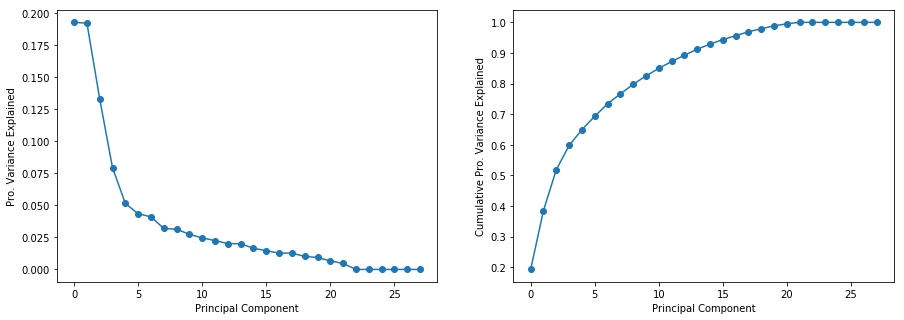

0.95 of variance explained by 17 principal components


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,p_cat_3_15,p_cat_3_16,p_cat_3_17,p_cat_3_18,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_8,p_cat_3_9
0,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
1,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
2,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
3,-0.208597,-1.979441,0.694416,0.885650,0.772876,1.407854,-0.463428,-0.160788,-0.240930,0.525191,...,0,0,0,0,0,0,0,0,0,0
4,1.324356,1.013547,-0.024387,-0.432656,-0.236465,-0.174523,-0.124989,-0.153652,-0.326405,0.684448,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X_fa, fa_cols = create_fa_modeldf(X, demo_cols, per_variance_captured = .95)
X_fa.head()

In [8]:
# Generates k-means cluster datasets
# returns whole dataframe with clusters and cluster split dataframes
def create_cluster_modeldfs(X, y, demo_cols, n_clusters = 3, drop_demo = True):
    kmeansdf = X[demo_cols]
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 20, precompute_distances = True, n_jobs = -1).fit(kmeansdf) # testing shows that 2-3 clussters works the best
    cluster_nums = kmeans.predict(kmeansdf)

    # Single dataset for clusters
    X_cluster = pd.DataFrame(cluster_nums, columns = ['cluster_num'])
    if drop_demo:
        X_cluster = X_cluster.join(X.drop(demo_cols, axis = 1))
    else:
        X_cluster = X_cluster.join(X)
        
    
    # Seperate datasets based on clusters
    temp = X_cluster.join(y)
    X_clusters = [temp[temp['cluster_num'] == x] for x in range(max(temp['cluster_num']) + 1)]
    X_clusters = [cluster.drop('cluster_num', axis = 1) for cluster in X_clusters]
    
    return X_cluster, X_clusters

In [13]:
try:
    print("Clustering Using FA\n")
    X_fa_cluster, _ = create_cluster_modeldfs(X_fa, y, fa_cols, n_clusters = 3, drop_demo = True)
    print("Done!")
except:
    print ("Create model dataframe first!")

Clustering Using FA

Done!


In [14]:
X_fa_cluster.head()

,cluster_num,p_cat_1_1,p_cat_1_10,p_cat_1_11,p_cat_1_12,p_cat_1_13,p_cat_1_14,p_cat_1_15,p_cat_1_16,p_cat_1_17,...,p_cat_3_15,p_cat_3_16,p_cat_3_17,p_cat_3_18,p_cat_3_3,p_cat_3_4,p_cat_3_5,p_cat_3_6,p_cat_3_8,p_cat_3_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# uses the minimal_preprocess dataset
def write_cluster_dataset(X_cl):
    min_df = pd.read_csv("inputs/minimal_preprocess.csv")
    min_demo = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    start = pd.DataFrame(min_df['u_id']).join(min_df['p_id'])
    some = ['p_cat_1','p_cat_2','p_cat_3']
    outcluster = start.join(pd.DataFrame(X_cl['cluster_num'])).join(min_df.drop(['u_id', 'p_id'], axis = 1))
    outcluster.to_csv("inputs/user_clusters.csv", encoding='utf-8', index = False)
    return outcluster

In [16]:
outcluster = write_cluster_dataset(X_fa_cluster)
outcluster.head()

,u_id,p_id,cluster_num,gender,age,occ,city,years_in_city,married,p_cat_1,p_cat_2,p_cat_3,pur
0,1,69042,0,0,0,10,0,2,0,3,0,0,8370
1,1,248942,0,0,0,10,0,2,0,1,6,14,15200
2,1,87842,0,0,0,10,0,2,0,12,0,0,1422
3,1,85442,0,0,0,10,0,2,0,12,14,0,1057
4,2,285442,2,1,6,16,2,4,0,8,0,0,7969


# Creating Recommender

In [31]:
def create_cluster_pred_pur():
    try:
        with ZipFile('inputs/xgb_modeldf.zip', 'r') as zip:
            zip.extractall('inputs/')
        print("Found buffer zip file")
        dmodel = xgb.DMatrix('inputs/xgb_modeldf.buffer')
    except:
        print("Save modeldf buffer first! Do you have the buffer zip file?")
        return 0
    
    try:
        bst = xgb.Booster({'nthread': 4})  # init model
        bst.load_model('inputs/xgb_black_friday_model.bin')  # load data
        predictions = bst.predict(dmodel)
    except:
        print("Save xgb model first!")
        return 0

    user_clusterdf = pd.read_csv("inputs/user_clusters.csv")
    user_pred_clusterdf = user_clusterdf.join(pd.DataFrame(data = predictions, columns = ['pur_pred']))

    unique_clusters = user_pred_clusterdf['cluster_num'].unique()
    unique_clusters.sort()

    for cluster_num in unique_clusters:
        cluster = user_pred_clusterdf[user_pred_clusterdf['cluster_num'] == cluster_num]

        p_cats = ['p_cat_1', 'p_cat_2', 'p_cat_3']
        prod_cats = cluster['p_cat_1'].unique()
        prod_cats.sort()
        pur_sums = {x:0 for x in prod_cats}

        for cat in p_cats:
            prod_cats = cluster[cat].unique()
            prod_cats = prod_cats[prod_cats != 0]
            prod_cats.sort()
            for prod_cat in prod_cats:
                pur_sums[prod_cat] += cluster[cluster[cat] == prod_cat]['pur_pred'].sum()

        cluster_pur = pd.DataFrame(list(pur_sums.items()), columns = ['p_cat', 'total_pur_pred'])
        cluster_pur.to_csv("outputs/cluster_%d_pred_pur.csv" % cluster_num, encoding='utf-8', index = False)
        print("Wrote Cluster", cluster_num, "Predicted Purchase Information")
    return len(unique_clusters)

In [32]:
num_clusters = create_cluster_pred_pur()

Found buffer zip file
[03:06:40] 537577x69 matrix with 37092813 entries loaded from inputs/xgb_modeldf.buffer
Wrote Cluster 0 Predicted Purchase Information
Wrote Cluster 1 Predicted Purchase Information
Wrote Cluster 2 Predicted Purchase Information


In [33]:
# Reading top k product categories for each cluster
def top_k_cats(top_k = 10):
    top_k = min(max(top_k, 0), 18)
    for x in range(num_clusters):
        cluster_pur = pd.read_csv("outputs/cluster_%d_pred_pur.csv" % x)
        top_k_cats = cluster_pur.nlargest(top_k, 'total_pur_pred')['p_cat'].values
        print("Top %d product categories for cluster %d: %s" % (top_k, x, " ".join(str(cat) for cat in top_k_cats)))

In [34]:
k = 10

top_k_cats(k)

Top 10 product categories for cluster 0: 1 8 5 16 2 15 14 6 4 17
Top 10 product categories for cluster 1: 1 8 5 16 2 15 14 6 17 4
Top 10 product categories for cluster 2: 1 8 5 16 2 15 14 6 17 4
